## CNN With Image Rec

This CNN is trained for 400 epochs then asked to predict on images it has never seen.

In [2]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from functions import *

# Allow image embeding in notebook
%matplotlib inline

from os.path import join

import os

# Tools to load, view and process images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Used to build nets or layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Pretrained models loaded in keras for transfer learning
from keras.applications import VGG16

from keras.models import Model

from keras import optimizers


import numpy as np

Load in the data, and give each image a label based on their directory

In [3]:
# Load training and testing datasets.
ROOT_PATH = "traffic"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images, labels = load_data(train_data_dir)

In [4]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


## CNN

I am using keras to build this CNN

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# This Dense layer stands for how many labels I have. I have 62 labels so my Dense layer is 62
model.add(Dense(62))
model.add(Activation('softmax'))

model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])


# model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),    
#                 loss='categorical_crossentropy', 
#                 metrics=['accuracy'])

In [10]:
# Batch_size is how many images I show the CNN in one epoch
img_width = 32
img_height = 32
batch_size = 32

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling (we do not want to modify the testing data)
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    'traffic/datasets/BelgiumTS/Training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'traffic/datasets/BelgiumTS/Testing',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 4575 images belonging to 62 classes.
Found 2520 images belonging to 62 classes.


In [11]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))

In [12]:
def add_new_last_layer(base_model, nb_classes=62):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    # Get the output shape of the models last layer
    x = base_model.output
    # Convert final MxNxC tensor output into a 1xC tensor where C is the # of channels.
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x) 
    x = Dropout(.5)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [13]:
# This will freeze the weights on all the layers except for our new dense layer
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [14]:
tran_model = add_new_last_layer(base_model)
setup_to_transfer_learn(tran_model,base_model)

In [15]:
nb_epoch = 400

tran_model.fit_generator(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=143,
    validation_data=validation_generator,
    validation_steps=143)

Epoch 1/400
143/143 [==============================] - 6s 40ms/step - loss: 4.0839 - acc: 0.0468 - val_loss: 3.8610 - val_acc: 0.0620
Epoch 2/400
143/143 [==============================] - 4s 29ms/step - loss: 3.6993 - acc: 0.1220 - val_loss: 3.5731 - val_acc: 0.2364
Epoch 3/400
143/143 [==============================] - 4s 29ms/step - loss: 3.5163 - acc: 0.1832 - val_loss: 3.4091 - val_acc: 0.2884
Epoch 4/400
143/143 [==============================] - 4s 29ms/step - loss: 3.3957 - acc: 0.2175 - val_loss: 3.2971 - val_acc: 0.3081
Epoch 5/400
143/143 [==============================] - 4s 29ms/step - loss: 3.2858 - acc: 0.2597 - val_loss: 3.1970 - val_acc: 0.3224
Epoch 6/400
143/143 [==============================] - 4s 29ms/step - loss: 3.1786 - acc: 0.2940 - val_loss: 3.1062 - val_acc: 0.3398
Epoch 7/400
143/143 [==============================] - 4s 29ms/step - loss: 3.1133 - acc: 0.3064 - val_loss: 3.0291 - val_acc: 0.3526
Epoch 8/400
143/143 [==============================] - 4s 29ms

Epoch 62/400
143/143 [==============================] - 4s 29ms/step - loss: 1.7038 - acc: 0.5639 - val_loss: 1.6457 - val_acc: 0.5539
Epoch 63/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6847 - acc: 0.5709 - val_loss: 1.6567 - val_acc: 0.5496
Epoch 64/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6650 - acc: 0.5746 - val_loss: 1.6283 - val_acc: 0.5554
Epoch 65/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6599 - acc: 0.5753 - val_loss: 1.6288 - val_acc: 0.5561
Epoch 66/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6551 - acc: 0.5751 - val_loss: 1.6264 - val_acc: 0.5568
Epoch 67/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6279 - acc: 0.5817 - val_loss: 1.6041 - val_acc: 0.5649
Epoch 68/400
143/143 [==============================] - 4s 29ms/step - loss: 1.6310 - acc: 0.5814 - val_loss: 1.6045 - val_acc: 0.5623
Epoch 69/400
143/143 [==============================] -

143/143 [==============================] - 4s 29ms/step - loss: 1.1483 - acc: 0.6710 - val_loss: 1.1635 - val_acc: 0.6566
Epoch 183/400
143/143 [==============================] - 4s 29ms/step - loss: 1.1614 - acc: 0.6743 - val_loss: 1.1753 - val_acc: 0.6498
Epoch 184/400
143/143 [==============================] - 4s 29ms/step - loss: 1.1541 - acc: 0.6828 - val_loss: 1.1691 - val_acc: 0.6596
Epoch 185/400
143/143 [==============================] - 4s 29ms/step - loss: 1.1508 - acc: 0.6789 - val_loss: 1.1611 - val_acc: 0.6556
Epoch 186/400
143/143 [==============================] - 4s 29ms/step - loss: 1.1559 - acc: 0.6717 - val_loss: 1.1673 - val_acc: 0.6548
Epoch 187/400
143/143 [==============================] - 4s 29ms/step - loss: 1.1437 - acc: 0.6789 - val_loss: 1.1645 - val_acc: 0.6566
Epoch 188/400
143/143 [==============================] - 4s 29ms/step - loss: 1.1536 - acc: 0.6769 - val_loss: 1.1583 - val_acc: 0.6579
Epoch 189/400
143/143 [==============================] - 4s 29

143/143 [==============================] - 4s 29ms/step - loss: 0.9596 - acc: 0.7215 - val_loss: 1.0123 - val_acc: 0.6952
Epoch 303/400
143/143 [==============================] - 4s 29ms/step - loss: 0.9592 - acc: 0.7193 - val_loss: 1.0286 - val_acc: 0.6853
Epoch 304/400
143/143 [==============================] - 4s 29ms/step - loss: 0.9440 - acc: 0.7248 - val_loss: 1.0186 - val_acc: 0.6906
Epoch 305/400
143/143 [==============================] - 4s 29ms/step - loss: 0.9499 - acc: 0.7243 - val_loss: 1.0161 - val_acc: 0.6901
Epoch 306/400
143/143 [==============================] - 4s 30ms/step - loss: 0.9352 - acc: 0.7320 - val_loss: 1.0232 - val_acc: 0.6872
Epoch 307/400
143/143 [==============================] - 4s 29ms/step - loss: 0.9544 - acc: 0.7198 - val_loss: 1.0104 - val_acc: 0.6908
Epoch 308/400
143/143 [==============================] - 4s 29ms/step - loss: 0.9515 - acc: 0.7213 - val_loss: 1.0262 - val_acc: 0.6875
Epoch 309/400
143/143 [==============================] - 4s 29

In [16]:
for i, layer in enumerate(tran_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 global_average_pooling2d_1 True
20 dense_3 True
21 dropout_2 True
22 dense_4 True


In [17]:
def setup_to_finetune(model, layer_level):
    """Freeze the bottom layer_level layers and train the rest

    Args:
     model: keras model
    """
    for layer in model.layers[:layer_level]:
        layer.trainable = False
    for layer in model.layers[layer_level:]:
        layer.trainable = True

In [18]:
#unfreeze all layers after the 3rd block (after pooling)
setup_to_finetune(tran_model,10)

In [19]:
for i, layer in enumerate(tran_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d_1 True
20 dense_3 True
21 dropout_2 True
22 dense_4 True


## Prediction 

I first load in an image that is pretty basic and run a prediction on it

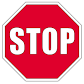

In [35]:
load_img('data/stop_sign_original/pic_002.jpg')

In [36]:
img = load_img('data/stop_sign_original/pic_002.jpg',target_size=(32,32) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
img.shape

(1, 32, 32, 3)

It only gives 3 labels a positive prediction. So it false positives only twice on this image. 

In [22]:
pred = tran_model.predict(img)
pred

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        3.1302901e-13, 7.0546113e-16, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

Each value in the array stands for the probability of the image being that sign. The index values of the array correspond to the label numbers. Index 0 is label 0.

In [23]:
a = pred.tolist()

In [25]:
an = a[0]

an.index(max(an))

32

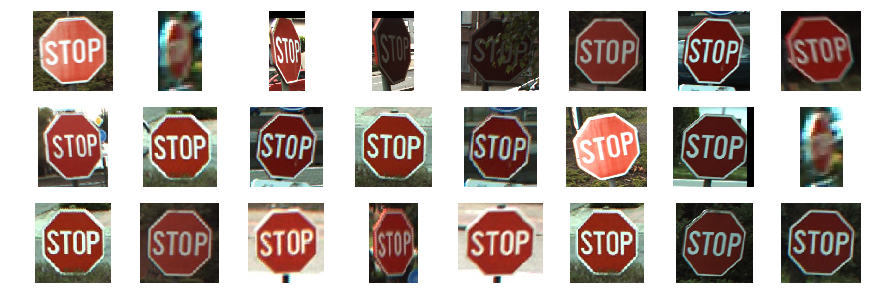

In [34]:
display_label_images(images, 21)

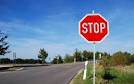

In [38]:
load_img('data/stop_sign_original/pic_012.jpg')

In [39]:
img = load_img('data/stop_sign_original/pic_002.jpg',target_size=(32,32) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
img.shape

(1, 32, 32, 3)

In [40]:
pred = tran_model.predict(img)
pred

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        3.1302901e-13, 7.0546113e-16, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

In [42]:
a = pred.tolist()
an = a[0]
an.index(max(an))

32

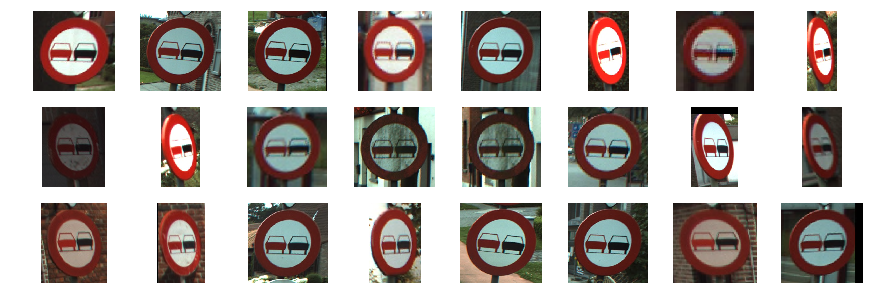

In [56]:
display_label_images(images, 31)

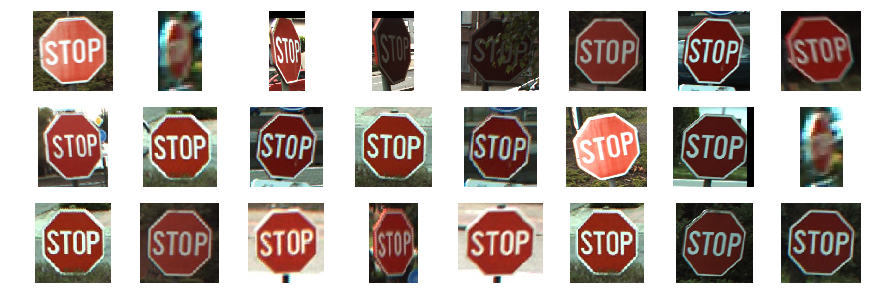

In [57]:
display_label_images(images, 21)

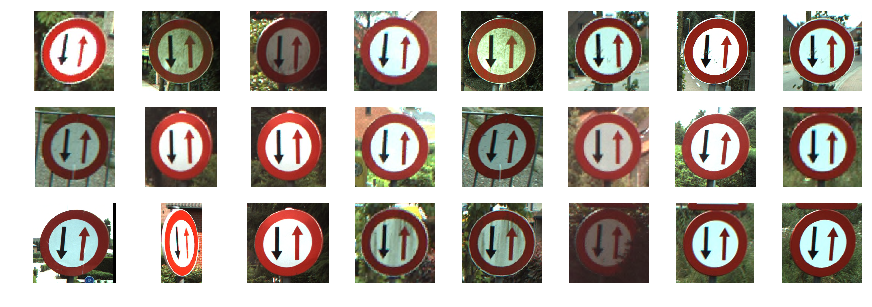

In [58]:
display_label_images(images, 20)

## Example of a Bad Prediction

This is an example of a bad prediction on an image. It false positves to many times!

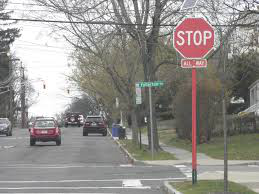

In [45]:
load_img('data/stop_sign_original/pic_043.jpg')

In [46]:
img = load_img('data/stop_sign_original/pic_043.jpg',target_size=(32,32) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
img.shape

(1, 32, 32, 3)

In [47]:
pred = tran_model.predict(img)
pred

array([[0.00000000e+00, 2.97089593e-32, 0.00000000e+00, 0.00000000e+00,
        3.60803547e-28, 4.36888051e-24, 3.08567419e-17, 9.99821961e-01,
        8.87656456e-32, 3.58764873e-31, 1.77907044e-04, 1.01216360e-37,
        9.62804939e-29, 0.00000000e+00, 1.03101679e-30, 0.00000000e+00,
        0.00000000e+00, 1.01268114e-07, 2.46492051e-27, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.10456925e-20, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.05293209e-32,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.33181453e-34, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.25807425e-28, 8.18170347e-13, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.49713789e-28, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [49]:
a = pred.tolist()
an = a[0]
max(an)

0.9998219609260559

In [ ]:
#
an.index(max(an))